In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import ConnectionPatch


In [8]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df=pop_df[['Country Code','2018', '2003']].dropna()
pop_df['2018']=pop_df['2018'].astype(int)
possible_countries=pop_df.query(" `2018` >=1000000")['Country Code'].values
possible_countries=[x.lower() for x in possible_countries]

In [9]:
df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df=df[df['country'].isin(possible_countries)]
df=df.rename(columns={'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})

df=df[df['year'].isin(np.arange(2003, 2019, 1))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df=df[~df['subjarea'].isin(physical_sciences)]
df['year_arabspring']=df['year'].apply(lambda x: 'before' if x>=2003 and x<=2010 else 'after' )
df['is_internal_attention']=df['Mention_country']==df['Aff_country']
result_df=df.groupby(['Mention_country', 'year_arabspring', 'is_internal_attention'])['count'].sum().reset_index()


In [10]:
result_df.Mention_country.nunique()

159

In [11]:
# Group by `cat` and `Mention_country` and compute the ratio of `count` for `is_internal_attention=False` to the total `count` for each group
df_grouped = (
    result_df.groupby([ "Mention_country", "year_arabspring"])
    .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x.loc[x["is_internal_attention"] == True, "count"].sum())
    .reset_index(name="Foriegn2Internal_attention_ratio")
)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_33816\1104022864.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x.loc[x["is_internal_attention"] == True, "count"].sum())


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_33816\1532273032.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_33816\1532273032.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_33816\1532273032.py:18: SettingWithCopyWarning: 
A value is trying 

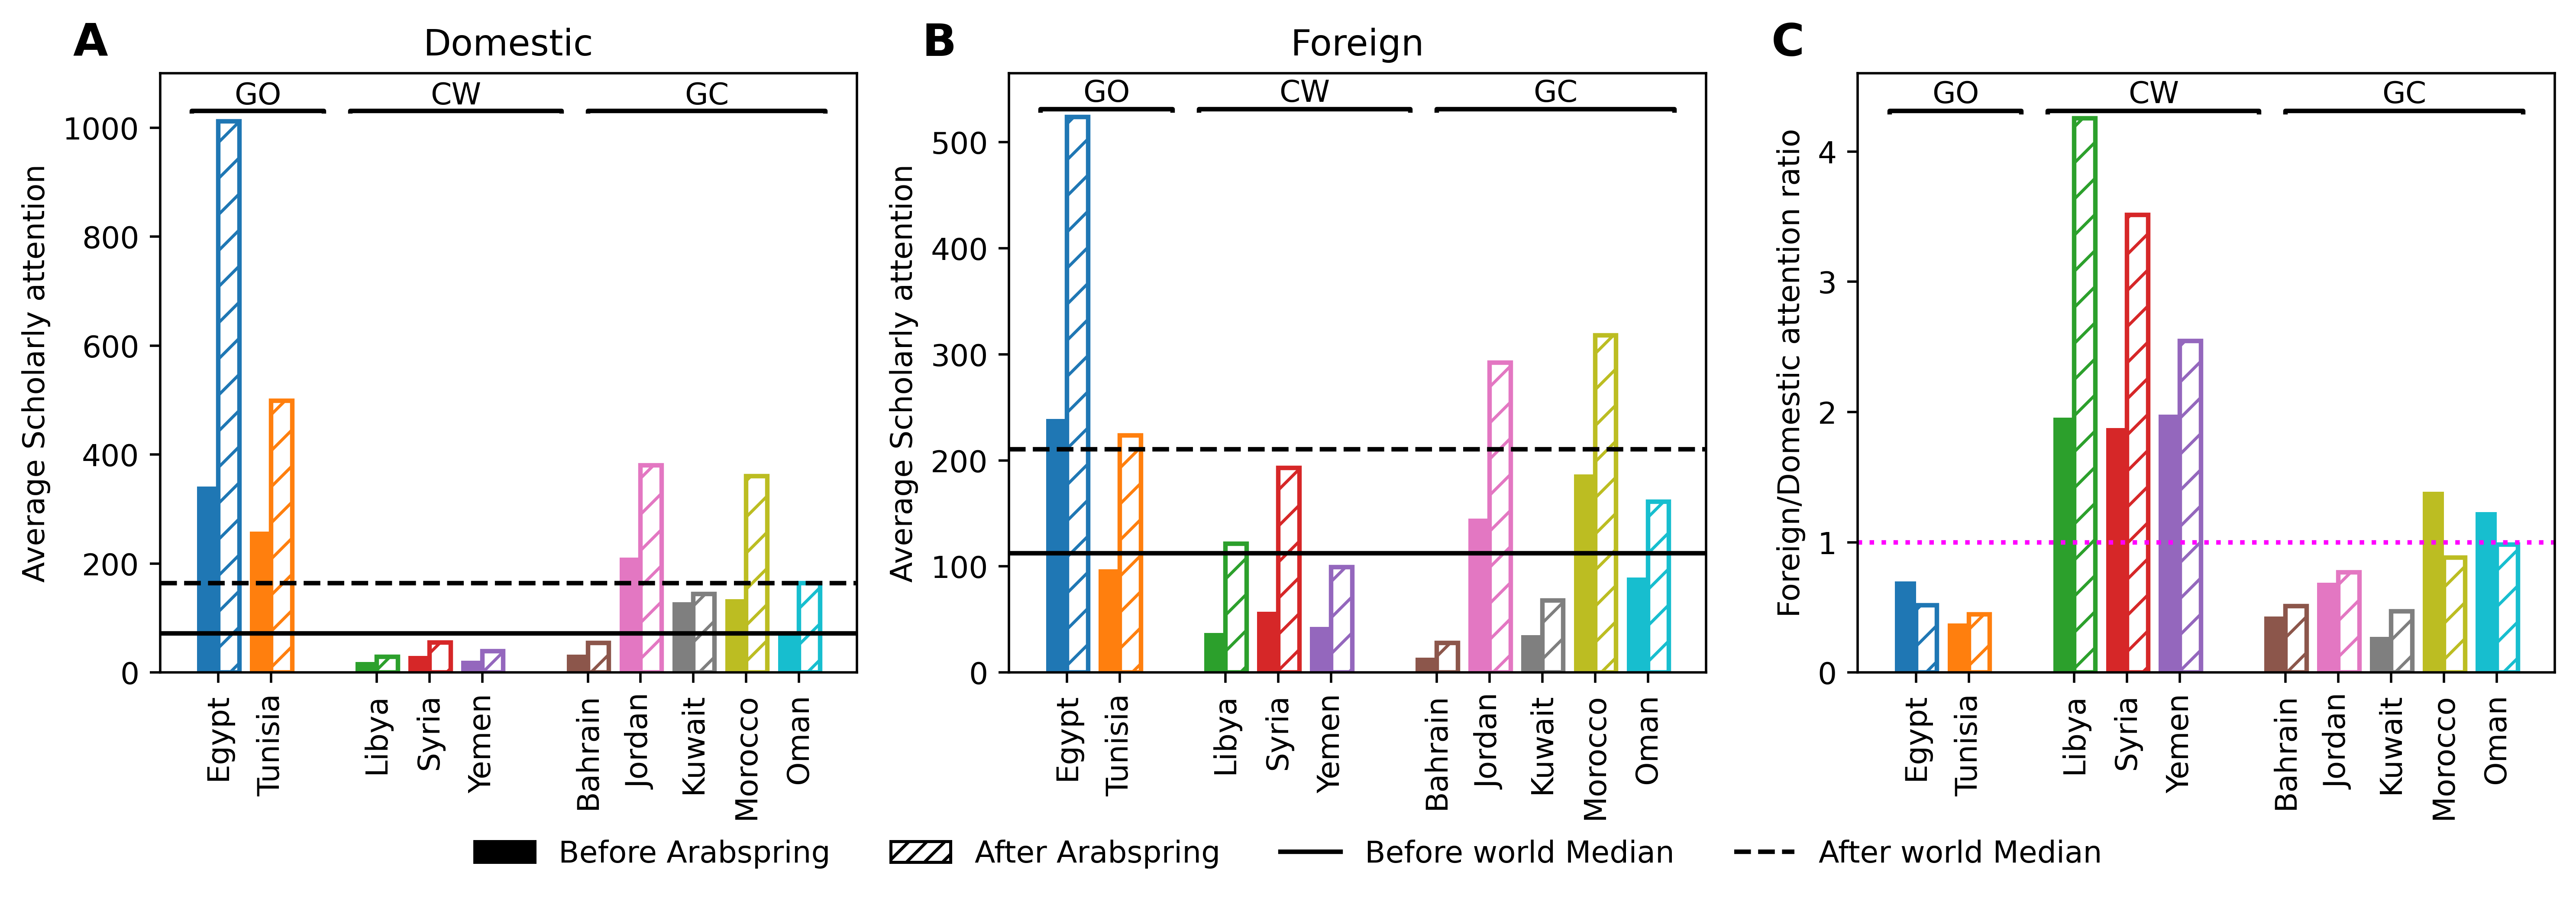

In [67]:
# Add brackets and messages
def add_bracket(axis, x_start, x_end, y, text, ratio=1):
    """Add a bracket with text between two x positions."""
    axis.plot([x_start, x_start, x_end, x_end], [y, y + 1*ratio, y + 1*ratio, y], color="black", lw=1.5)
    axis.text((x_start + x_end) / 2, y +2.5*ratio, text, ha='center', va='bottom', fontsize=10)

Country_list = {'Egypt':'EGY', 'Tunisia':'TUN', 'Libya':'LBY', 'Syria':'SYR', 'Yemen':'YEM',
                'Bahrain':'BHR', 'Jordan':'JOR', 'Kuwait':'KWT', 'Morocco':'MAR', 'Oman':'OMN'}
rev_Country_list = {Country_list[key].lower(): key for key in Country_list}
country_names = list(Country_list.keys())
custom_colors = [f'C{i}' for i in range(10)]
fig, ax=plt.subplots(nrows=1,ncols=3, figsize=(12, 4), dpi=500)
Titles=['Domestic', 'Foreign']
subplot_labels = ['A', 'B', 'C', 'D']

for i, is_internal in enumerate([True, False]):
    subset = result_df.query(f'is_internal_attention == {is_internal} and Mention_country in @abbr')
    subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
    subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
    subset = subset.sort_values('sorted_order').drop(columns=['sorted_order'])

    # Reset the index if needed
    subset.reset_index(drop=True, inplace=True)
    x_labels = subset['Mention_country'].unique()
    x = np.array([0,1,3,4,5,7, 8, 9, 10, 11] ) # X positions for the bars
    subset['count']/=8
    width = 0.4  # Width of each bar
    before_data = subset[subset['year_arabspring'] == 'before']['count']
    after_data = subset[subset['year_arabspring'] == 'after']['count']
    
    ax[i].bar(
        x - width / 2, 
        before_data, 
        width=width, 
        color=custom_colors, 
        label='Before'
    )
    
    # Bars for 'after' with dashed patterns
    ax[i].bar(
        x + width / 2, 
        after_data, 
        width=width, 
        color='none', 
        edgecolor=custom_colors, 
        linewidth=1.5, 
        hatch='//', 
        label='After'
    )
    medians=result_df.query(f'is_internal_attention == {is_internal}').groupby('year_arabspring')['count'].median().to_dict()

    ax[i].axhline(medians['before']/8, color='k')
    ax[i].axhline(medians['after']/8, color='k', linestyle='--')
    
    # Set x-axis labels and title
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(x_labels, rotation=90)
    ax[i].set_title(Titles[i])
    
    # Add subplot label (A, B, C, D) to the top-left corner
    ax[i].text(-0.1, 1.05, subplot_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='center', ha='center')

ax[0].set_ylabel('Average Scholarly attention')
    
ax[1].set_ylabel('Average Scholarly attention')


subset = df_grouped.query(f'Mention_country in @abbr')
subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
subset = subset.sort_values('sorted_order').drop(columns=['sorted_order'])

# Reset the index if needed
subset.reset_index(drop=True, inplace=True)
x_labels = subset['Mention_country'].unique()
x = np.array([0,1,3,4,5,7, 8, 9, 10, 11] ) # X positions for the bars
width = 0.4  # Width of each bar
before_data = subset[subset['year_arabspring'] == 'before']['Foriegn2Internal_attention_ratio']
after_data = subset[subset['year_arabspring'] == 'after']['Foriegn2Internal_attention_ratio']

ax[2].bar(
    x - width / 2, 
    before_data, 
    width=width, 
    color=custom_colors, 
    label='Before'
)

# Bars for 'after' with dashed patterns
ax[2].bar(
    x + width / 2, 
    after_data, 
    width=width, 
    color='none', 
    edgecolor=custom_colors, 
    linewidth=1.5, 
    hatch='//', 
    label='After'
)

ax[2].axhline(1, color='magenta', linestyle=':')

# Set x-axis labels and title
ax[2].set_xticks(x)
ax[2].set_xticklabels(x_labels, rotation=90)
#ax[i].set_ylim(0, 3500)

# Add subplot label (A, B, C, D) to the top-left corner
ax[2].text(-0.1, 1.05, 'C', transform=ax[2].transAxes, fontsize=15, fontweight='bold', va='center', ha='center')
ax[2].set_ylabel('Foreign/Domestic attention ratio')
    




# Create custom legend handles for the boxes
solid_box = mpatches.Patch(facecolor='k', edgecolor='k', label='Before Arabspring')  # Solid box
dashed_box = mpatches.Patch(facecolor='white', edgecolor='k', hatch='////', label='After Arabspring')  # Dashed pattern inside
    # Create custom legend handles with grey color
before_handle = mlines.Line2D([], [], color='k', label='Before world Median')
after_handle = mlines.Line2D([], [], color='k', label='After world Median', linestyle='--')

    # Add the legend with custom handles
lgd=fig.legend(handles=[solid_box, dashed_box, before_handle,after_handle], loc='lower center', frameon=False, ncol=4,bbox_to_anchor=(0.5, -0.05))

# Adding brackets for each group
add_bracket(ax[0], -0.5, 2, 1030, "GO")
add_bracket(ax[0], 2.5, 6.5, 1030, "CW")
add_bracket(ax[0], 7, 11.5, 1030, "GC")
ax[0].set_ylim(0, 1100)


# Adding brackets for each group
add_bracket(ax[1], -0.5, 2, 530, "GO")
add_bracket(ax[1], 2.5, 6.5, 530, "CW")
add_bracket(ax[1], 7, 11.5, 530, "GC")
ax[1].set_ylim(0, 565)




add_bracket(ax[2], -0.5, 2, 4.3, "GO",0.01)
add_bracket(ax[2], 2.5, 6.5, 4.3, "CW",0.01)
add_bracket(ax[2], 7, 11.5, 4.3, "GC",0.01)
ax[2].set_ylim(0, 4.6)
plt.tight_layout()
fig.savefig('Figure2.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


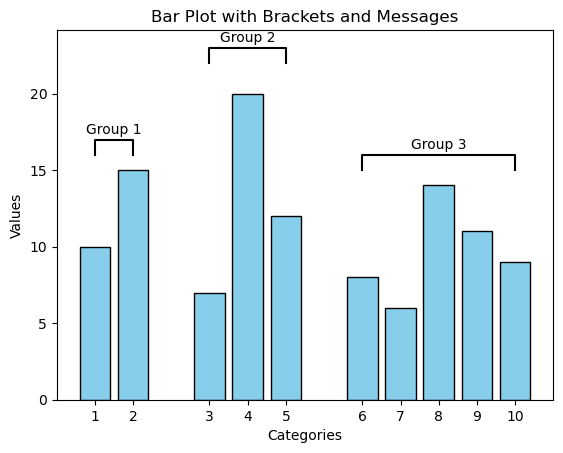

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
values = [10, 15, 7, 20, 12, 8, 6, 14, 11, 9]

# Define custom positions with gaps
positions = [0, 1, 3, 4, 5, 7, 8, 9, 10, 11]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(positions, values, width=0.8, color='skyblue', edgecolor='black')




# Adjust x-ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(categories)
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Bar Plot with Brackets and Messages')

# Show the plot
plt.show()
